# scRNAseq Analysis PT 1: Quality Control

> **CONDA ENV:** scrnaseq_workflow e scRNA_NEW

## Quality Control code structure

This QC codebase is organized in **three conceptual layers**, designed to keep the workflow modular, transparent, and easy to maintain.

---

## 1) Base functions layer

The first layer contains the **core QC utility functions**.  
These functions implement single, well-defined operations, such as:

- Loading and preparing AnnData objects
- Computing QC metrics
- Detecting and filtering doublets
- Filtering low-quality cells
- Generating standard QC plots
- Building QC summary tables

They are intentionally **stateless and reusable**, and do not enforce a specific analysis flow.  
This layer provides the building blocks for all downstream QC steps.

---

## 2) QC application layer (`QC_PT1` and `QC_PT2`)

The second layer defines **how the base functions are combined** into meaningful QC stages.

### `QC_PT1` — exploratory QC
- Loads data and computes initial QC metrics
- Runs Scrublet to estimate doublet scores
- Generates diagnostic plots (histograms, optional UMAPs)
- **Does not apply filtering**
- Its goal is to support **data-driven decision-making**, especially for choosing the Scrublet threshold
- **SET UP THE PARAMETERS AND APPLY THE NEXT STEP**

### `QC_PT2` — final QC and filtering
- Applies doublet filtering using a fixed, user-defined threshold
- Filters low-quality cells based on QC cutoffs
- Updates QC summaries before and after filtering
- Concatenates all samples
- Generates final QC plots and summary tables
- Optionally exports filtered datasets

This layer encodes the **QC logic**, while still remaining configurable and reproducible.

---

## 3) Execution layer (high-level user input)

The third layer is the **analysis entry point**, where the user:

- Defines paths, samples, and QC parameters
- Chooses thresholds and cutoffs
- Calls `QC_PT1` and `QC_PT2`
- Generates figures and exports final results

# FUNCTIONS AND PACKAGES

## Packs and configs

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#### Configurações de plotagem ####
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.facecolor'] = 'white'

# grade leve em todos os plots
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.color'] = 'grey'

# bordas mais suaves
mpl.rcParams['axes.edgecolor'] = '0.8'

# fonte padrão mais clean
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12

## 1th LAYER

### 1. Data importing and pre-processing

In [ ]:
def ImportData_H5(h5_file_name, sample_name='', tissue='', condition='', x10=True):
    """
    Load a count matrix into an AnnData object and attach basic sample metadata.

    Parameters
    ----------
    h5_file_name : str
        Path to the input file. If x10=True, this should be a 10x Genomics HDF5
        (e.g., filtered_feature_bc_matrix.h5). Otherwise, any format supported
        by scanpy.read() (e.g., .h5ad).
    sample_name : str, optional
        Sample identifier to store in adata.obs["sample"].
    tissue : str, optional
        Tissue label to store in adata.obs["tissue"].
    condition : str, optional
        Experimental condition to store in adata.obs["condition"].
    x10 : bool, default True
        If True, read as 10x HDF5 using sc.read_10x_h5(). If False, use sc.read().

    Returns
    -------
    adata : anndata.AnnData
        Loaded object with metadata columns added and gene names made unique.
    """
    # Read the input data: either a 10x HDF5 matrix or a generic Scanpy-readable file
    if x10:
        adata = sc.read_10x_h5(h5_file_name)
    else:
        adata = sc.read(h5_file_name)

    # Attach minimal metadata to each cell
    adata.obs["sample"] = sample_name
    adata.obs["tissue"] = tissue
    adata.obs["condition"] = condition

    # Set index names for clarity (useful for exports/debugging)
    adata.obs.index.name = 'cells'
    adata.var.index.name = 'genes'

    # Ensure gene symbols are unique (10x datasets often contain duplicated gene names)
    adata.var_names_make_unique()

    return adata

def ProcessaInputAdata(cellbender_file_path, raw_file_path, sample_name, tissue, condition, x10=True):
    """
    Load CellBender-corrected counts and the corresponding raw counts, then store both as layers.

    This function:
    - Loads the CellBender output (treated as the main matrix)
    - Loads the raw 10x matrix (or other format if x10=False)
    - Stores CellBender counts in adata.layers["cellbender"]
    - Stores raw counts in adata.layers["raw_counts"] aligned to the same cells
    - Sets adata.X to the CellBender layer (active matrix for downstream steps)

    Parameters
    ----------
    cellbender_file_path : str
        Path to the CellBender output matrix file.
    raw_file_path : str
        Path to the corresponding raw matrix file (same sample).
    sample_name : str
        Sample identifier.
    tissue : str
        Tissue label.
    condition : str
        Experimental condition label.
    x10 : bool, default True
        If True, treat inputs as 10x HDF5 and use sc.read_10x_h5(). Otherwise use sc.read().

    Returns
    -------
    adata : anndata.AnnData
        AnnData object with CellBender counts as the active matrix (adata.X) and both
        CellBender/raw counts stored in layers.
    adata_raw : anndata.AnnData
        Raw AnnData object (subset to the same cells as adata).
    """
    # Load CellBender-corrected and raw matrices
    adata = ImportData_H5(cellbender_file_path, sample_name=sample_name, tissue=tissue, condition=condition, x10=x10)
    adata_raw = ImportData_H5(raw_file_path, sample_name=sample_name, tissue=tissue, condition=condition, x10=x10)

    # Store the CellBender-corrected counts as a layer
    adata.layers["cellbender"] = adata.X.copy()

    # Align raw to the exact same cell barcodes present in the CellBender object
    adata_raw = adata_raw[adata.obs.index, :]

    # Store raw counts as a second layer (useful for comparisons/QC)
    adata.layers["raw_counts"] = adata_raw.X.copy()

    # Set the active matrix to CellBender counts for downstream analysis
    adata.X = adata.layers["cellbender"]

    # Optional: some pipelines strip "-1" from 10x barcodes; keep commented unless needed
    # adata.obs_names = adata.obs_names.str.replace("-1$", "", regex=True)

    return adata, adata_raw


### 2. Concatenate

In [ ]:
def CatAdata(adatas_list: list, keys: list):
    """
    Concatenate multiple AnnData objects into a single AnnData.

    Notes
    -----
    - Uses an outer join on genes to keep the union of features across datasets.
    - Adds a 'sample' column to adata.obs from the provided keys.
    - Prefixes cell barcodes with sample keys using index_unique='-'
      to avoid collisions across samples.

    Parameters
    ----------
    adatas_list : list[anndata.AnnData]
        List of AnnData objects to concatenate.
    keys : list[str]
        Sample keys (same length as adatas_list). These will populate the 'sample'
        label and be used to make cell IDs unique.

    Returns
    -------
    adata_concat : anndata.AnnData
        Concatenated object containing all cells and the union of genes.
    """
    # Concatenate all datasets (cell IDs become unique via sample-key prefixing)
    adata_concat = ad.concat(
        adatas_list,
        join="outer",
        label="sample",
        keys=keys,
        merge='same',
        uns_merge='same',
        index_unique='-'
    )

    print(f"Concatenated AnnData with {adata_concat.n_obs} cells and {adata_concat.n_vars} genes.")
    return adata_concat

### 3. Doublet detection

In [ ]:
def UmapScrublet(adata_input, threshold=0.25, save_plot=False, show_plot=True):
    """
    Compute a UMAP embedding using Scrublet outputs and generate two plots:
      1) UMAP colored by continuous Scrublet doublet_score
      2) UMAP colored by the binary doublet prediction (based on a chosen threshold)

    Notes
    -----
    - This function assumes `adata_input.obs["doublet_score"]` already exists and that
      a column named f"predicted_doublet_thr{threshold}" exists (created by DetectDoubletsScroublet).
    - The function creates a copy of the AnnData to avoid modifying the original object.

    Parameters
    ----------
    adata_input : anndata.AnnData
        Input AnnData containing Scrublet results in .obs.
    threshold : float, default 0.25
        Threshold used to label predicted doublets. Used only to choose the column name
        and in output filenames/titles.
    save_plot : bool or str/Path, default False
        If False, do not save figures. If a path-like value, create the directory
        (if needed) and save plots there.
    show_plot : bool, default True
        Whether to display plots interactively.

    Returns
    -------
    fig2 : matplotlib.figure.Figure or None
        The figure object for the binary (predicted doublets) UMAP plot.
        (Useful if you want to further customize or close it.)
    """
    # If save_plot is a path, ensure the directory exists
    if save_plot:
        save_plot = Path(save_plot)
        save_plot.mkdir(parents=True, exist_ok=True)

    # Work on a copy to avoid side effects on the original AnnData
    adata = adata_input.copy()

    # ---- Basic preprocessing to compute UMAP for visualization ----
    # Normalize counts per cell to a fixed total, log-transform, select HVGs,
    # then compute PCA/neighbors/UMAP on the HVGs
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var['highly_variable']].copy()

    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    # ---- Plot 1: continuous Scrublet score ----
    fig1 = sc.pl.umap(
        adata,
        color="doublet_score",
        cmap="viridis",
        show=show_plot,
        return_fig=True
    )
    if save_plot:
        fig1.savefig(
            f"{save_plot}/umap_score_scrublet_thr{threshold}.png",
            dpi=300,
            bbox_inches="tight"
        )

    # ---- Plot 2: binary predicted doublets ----
    fig2 = sc.pl.umap(
        adata,
        color=f"predicted_doublet_thr{threshold}",
        palette=["#2ca02c", "#d62728"],
        title=f"Predicted doublets (threshold={threshold})",
        show=show_plot,
        return_fig=True
    )
    if save_plot:
        fig2.savefig(
            f"{save_plot}/umap_bool_scrublet_thr{threshold}.png",
            dpi=300,
            bbox_inches="tight"
        )

    #return fig2


def DetectDoubletsScroublet(
    adata,
    suffix='',
    batch_key=None,  # e.g., use 'sample' when running on a concatenated object
    threshold=0.25,
    save_plot=False,  # if saving, provide a directory path
    show_plot=True,
    umap: bool = False,
):
    """
    Run Scrublet on an AnnData object, store doublet-related columns in .obs,
    and optionally generate QC plots (histogram and UMAP).

    What this function does
    -----------------------
    - Runs `sc.pp.scrublet(...)` (optionally per batch) to compute:
        * adata.obs["doublet_score"] (continuous)
        * adata.obs["predicted_doublet"] (boolean)
    - Renames "predicted_doublet" to include the chosen threshold in the column name:
        * f"predicted_doublet_thr{threshold}"
    - Plots:
        * scrublet score distribution histogram
        * optional UMAP colored by score and binary prediction (via UmapScrublet)

    Parameters
    ----------
    adata : anndata.AnnData
        Input AnnData.
    suffix : str, default ''
        Suffix to append to output filenames (useful to identify the sample/run).
    batch_key : str or None, default None
        Column in adata.obs used to run Scrublet per batch. Common choice is "sample"
        when multiple samples were concatenated.
    threshold : float, default 0.25
        Scrublet threshold for calling predicted doublets.
    save_plot : bool or str/Path, default False
        If False, do not save figures. If a path-like value, create the directory
        (if needed) and save plots there.
    show_plot : bool, default True
        Whether to display plots interactively.
    umap : bool, default False
        If True, run UMAP visualization plots using UmapScrublet.

    Returns
    -------
    adata : anndata.AnnData
        The same AnnData object with Scrublet annotations added to .obs.
    """
    # If save_plot is a path, ensure the directory exists
    if save_plot:
        save_plot = Path(save_plot)
        save_plot.mkdir(parents=True, exist_ok=True)

    # ---- Run Scrublet ----
    # expected_doublet_rate is dataset-dependent; here it is fixed at 0.06
    sc.pp.scrublet(
        adata,
        batch_key=batch_key,
        expected_doublet_rate=0.06,
        threshold=threshold
    )

    # Rename the boolean column to include the threshold value in its name
    colname = f"predicted_doublet_thr{threshold}"
    if "predicted_doublet" in adata.obs:
        adata.obs.rename(columns={"predicted_doublet": colname}, inplace=True)

    # ---- Plotting block (histogram + optional UMAP) ----
    if show_plot or save_plot:
        # Scrublet score distribution histogram
        fig_hist = sc.pl.scrublet_score_distribution(adata, show=show_plot, return_fig=True)

        if save_plot:
            fig_hist.savefig(
                f"{save_plot}/scrublet_hist_before_filtering_thr{threshold}_{suffix}.png",
                dpi=300,
                bbox_inches="tight"
            )

        # If plots are not shown, close to avoid memory accumulation in batch runs
        if not show_plot:
            plt.close(fig_hist)

        # Optional UMAP plots (score + binary)
        if umap:
            fig_umap = UmapScrublet(
                adata,
                threshold=threshold,
                save_plot=save_plot,
                show_plot=show_plot
            )

            if not show_plot and fig_umap is not None:
                plt.close(fig_umap)

    print(f"Number of doublets with threshold {threshold}: {adata.obs[colname].sum()}")

    return adata


In [ ]:
def FilterScrublet(adata, suffix='', threshold=None, show_plot=False, save_plot=False, umap=True):
    """
    Filter out predicted doublets using Scrublet outputs stored in `adata.obs`.

    This function:
    - Ensures a boolean column `predicted_doublet_thr{threshold}` exists in `adata.obs`
      (creates it from `doublet_score` if missing)
    - Subsets the AnnData to keep only singlets (predicted doublet == False)
    - Optionally generates Scrublet QC plots (histogram + optional UMAP)

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData containing at least `adata.obs["doublet_score"]`.
    suffix : str, default ''
        Suffix to append to output filenames (useful to identify a run/sample).
    threshold : float
        Threshold used to define predicted doublets from `doublet_score`.
    show_plot : bool, default False
        Whether to display plots interactively.
    save_plot : bool or str/Path, default False
        If False, do not save figures. If a path-like value, save plots to this directory.
    umap : bool, default True
        If True, generate UMAP plots via `UmapScrublet`.

    Returns
    -------
    adata_singlets : anndata.AnnData
        Filtered AnnData containing only singlets (predicted doublets removed).
    """

    # Column name storing the boolean doublet calls for this threshold
    colname = f"predicted_doublet_thr{threshold}"

    # If the threshold-specific column does not exist, create it from the continuous score
    if colname not in adata.obs:
        adata.obs[colname] = adata.obs["doublet_score"] >= threshold

    # Keep only singlets (cells not flagged as doublets)
    adata_singlets = adata[adata.obs[colname] == False].copy()

    # ---- Optional plotting block (histogram + optional UMAP) ----
    if show_plot or save_plot:
        # Scrublet score distribution histogram (before filtering)
        fig_hist = sc.pl.scrublet_score_distribution(adata, show=show_plot, return_fig=True)

        # Save histogram if requested
        if save_plot:
            fig_hist.savefig(
                f"{save_plot}/scrublet_hist_before_filtering_thr{threshold}_{suffix}.png",
                dpi=300,
                bbox_inches="tight"
            )

        # If not showing plots, close the figure to avoid memory accumulation
        if not show_plot:
            plt.close(fig_hist)

        # Optional UMAP plots (continuous score + binary calls)
        if umap:
            fig_umap = UmapScrublet(
                adata,
                threshold=threshold,
                save_plot=save_plot,
                show_plot=show_plot
            )

            if not show_plot and fig_umap is not None:
                plt.close(fig_umap)

    return adata_singlets


### 4. Low quality cell filtering

In [ ]:
## 1) Compute cell-level QC covariates and store them in the AnnData object
def QCmetric(adata):
    """
    Compute basic quality control (QC) metrics and annotate gene categories.

    This function:
    - Identifies mitochondrial, ribosomal, and hemoglobin genes based on gene names
    - Computes standard QC metrics per cell using Scanpy
    - Stores results directly in `adata.obs` and `adata.var`

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object containing raw count data.
    """

    # Identify mitochondrial, ribosomal, and hemoglobin genes based on naming patterns
    adata.var["mt"] = adata.var_names.str.contains(r"^(?i)MT-")
    adata.var["ribo"] = adata.var_names.str.contains(r"^(?i)RP[SL]")
    adata.var["hb"] = adata.var_names.str.contains(r"^HB(?!P)", case=False, regex=True)

    # Compute QC metrics per cell
    # This includes total counts, number of detected genes,
    # and the percentage of counts from mt/ribo/hb genes
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt", "ribo", "hb"],
        inplace=True,
        percent_top=[20],
        log1p=True
    )


## 2) Filter cells and genes based on QC covariates
def FilterOutliers(
    adata,
    min_genes_by_cell=100,
    max_genes_by_cell=None,
    min_cells_by_gene=20,
    min_total_counts=100,
    max_pct_mt=25,
    max_pct_ribo=None,
    max_pct_hb=None
):
    """
    Filter low-quality cells and lowly detected genes based on QC thresholds.

    This function:
    - Removes genes detected in fewer than `min_cells_by_gene` cells
    - Filters cells using a combination of mandatory and optional QC thresholds

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object with QC metrics already computed.
    min_genes_by_cell : int, default 100
        Minimum number of detected genes required per cell.
    max_genes_by_cell : int or None, default None
        Maximum number of detected genes allowed per cell (optional).
    min_cells_by_gene : int, default 20
        Minimum number of cells a gene must be detected in to be kept.
    min_total_counts : int, default 100
        Minimum total UMI counts required per cell.
    max_pct_mt : float, default 25
        Maximum percentage of mitochondrial counts allowed per cell.
    max_pct_ribo : float or None, default None
        Maximum percentage of ribosomal counts allowed per cell (optional).
    max_pct_hb : float or None, default None
        Maximum percentage of hemoglobin counts allowed per cell (optional).

    Returns
    -------
    adata : anndata.AnnData
        Filtered AnnData object.
    """

    # Remove genes detected in too few cells
    sc.pp.filter_genes(adata, min_cells=min_cells_by_gene)

    # Core filtering criteria applied to all cells
    mask = (
        (adata.obs["n_genes_by_counts"] > min_genes_by_cell) &
        (adata.obs["total_counts"] > min_total_counts) &
        (adata.obs["pct_counts_mt"] < max_pct_mt)
    )

    # Optional filtering criteria
    if max_genes_by_cell is not None:
        mask &= adata.obs["n_genes_by_counts"] < max_genes_by_cell
    if max_pct_ribo is not None:
        mask &= adata.obs["pct_counts_ribo"] < max_pct_ribo
    if max_pct_hb is not None:
        mask &= adata.obs["pct_counts_hb"] < max_pct_hb

    # Subset the AnnData object to keep only cells passing all filters
    adata = adata[mask].copy()

    return adata


## 3) Plot QC covariates for visual inspection
def PlotCovariates(adata, label, show_plot=False):
    """
    Visualize QC covariates using violin plots and scatter plots.

    This function generates:
    - Violin plots for total counts, number of genes, and mitochondrial percentage
    - A scatter plot of total counts vs. number of genes colored by mitochondrial percentage

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object with QC metrics computed.
    label : str
        Label used in plot titles (e.g., sample name or processing stage).
    show_plot : bool, default False
        Whether to display the plots interactively.

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object containing all QC plots.
    """

    # Create a 1x4 layout for QC plots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Total counts per cell
    sc.pl.violin(adata, 'total_counts', ax=axes[0], show=False, jitter=0.4)
    axes[0].set_title(f"{label} \n Total Counts")

    # Number of detected genes per cell
    sc.pl.violin(adata, "n_genes_by_counts", ax=axes[1], show=False, jitter=0.4)
    ymin = adata.obs["n_genes_by_counts"].min()
    axes[1].set_ylim(ymin * 0.95, None)  # Extend y-axis slightly below the minimum
    axes[1].set_title(f"{label} \n N Genes by Counts")

    # Percentage of mitochondrial counts
    sc.pl.violin(adata, "pct_counts_mt", ax=axes[2], show=False, jitter=0.4)
    axes[2].set_title(f"{label} \n Mitochondrial Counts (%)")

    # Scatter plot: total counts vs number of genes, colored by mitochondrial percentage
    scv.pl.scatter(
        adata,
        x="total_counts",
        y="n_genes_by_counts",
        color="pct_counts_mt",
        ax=axes[3],
        show=False
    )
    axes[3].set_title(
        f"{label}\nTotal Counts vs. Genes by Counts \nvs. Pct Mitochondrial Counts"
    )

    plt.subplots_adjust(wspace=0.4)

    # Show or close the figure depending on user preference
    if show_plot:
        plt.show()
    else:
        plt.close(fig)

    return fig


In [ ]:
def BoxplotMetricPairs(
    adatas_a, adatas_b, sample_names,
    metric="n_genes_by_counts",
    labels=("original", "filtered"),
    palette=("green", "purple"),
    group_gap=2.6, pair_offset=0.35, box_width=0.6,
    annot_fs=8, median_fs=9,
    y_top_pad=0.12   # fraction of extra space above the global maximum
):
    """
    Create paired boxplots comparing the same QC metric across two conditions
    (e.g., before vs after filtering) for multiple samples.

    For each sample, two boxplots are shown side by side:
    - one from `adatas_a`
    - one from `adatas_b`

    The function also annotates each boxplot with Tukey statistics:
    - n (number of cells)
    - lo / hi (lower and upper whiskers)
    - Q1 / median / Q3

    Parameters
    ----------
    adatas_a : list[anndata.AnnData]
        List of AnnData objects representing condition A (e.g., original).
    adatas_b : list[anndata.AnnData]
        List of AnnData objects representing condition B (e.g., filtered).
    sample_names : list[str]
        Sample names, one per AnnData pair.
    metric : str, default "n_genes_by_counts"
        Column in `adata.obs` to be plotted.
    labels : tuple[str, str], default ("original", "filtered")
        Labels for the legend corresponding to conditions A and B.
    palette : tuple[str, str], default ("green", "purple")
        Colors for the boxplots of conditions A and B.
    group_gap : float, default 2.6
        Horizontal spacing between sample groups.
    pair_offset : float, default 0.35
        Horizontal offset between paired boxplots within the same sample.
    box_width : float, default 0.6
        Width of each boxplot.
    annot_fs : int, default 8
        Font size for annotation text.
    median_fs : int, default 9
        Font size for median annotation.
    y_top_pad : float, default 0.12
        Fraction of extra space added above the maximum value to keep annotations visible.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated figure.
    ax : matplotlib.axes.Axes
        The axis containing the boxplots.
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    # Ensure consistent input lengths
    assert len(adatas_a) == len(adatas_b) == len(sample_names)

    # Extract valid (finite) values for the chosen metric
    def _vals(ad):
        if metric not in ad.obs:
            raise KeyError(f"'{metric}' not found in .obs.")
        arr = ad.obs[metric].to_numpy()
        return arr[np.isfinite(arr)]

    data_a = [_vals(ad) for ad in adatas_a]
    data_b = [_vals(ad) for ad in adatas_b]

    # Create figure and define x-axis positions
    fig, ax = plt.subplots(figsize=(14, 8))
    centers = np.arange(len(sample_names)) * group_gap
    pos_a = centers - pair_offset
    pos_b = centers + pair_offset

    # Draw boxplots for both conditions
    bp_a = ax.boxplot(
        data_a, positions=pos_a, widths=box_width,
        patch_artist=True, showfliers=False, whis=1.5
    )
    bp_b = ax.boxplot(
        data_b, positions=pos_b, widths=box_width,
        patch_artist=True, showfliers=False, whis=1.5
    )

    # Style boxplots
    for p in bp_a["boxes"]:
        p.set_facecolor(palette[0])
        p.set_alpha(0.6)
    for p in bp_b["boxes"]:
        p.set_facecolor(palette[1])
        p.set_alpha(0.6)
    for bp in (bp_a, bp_b):
        for k in ("medians", "whiskers", "caps"):
            for line in bp[k]:
                line.set_linewidth(1.5)

    # Vertical offsets for annotations (relative to y-range)
    y_min, y_max = ax.get_ylim()
    yr = y_max - y_min
    vpad_hi_small = 0.012 * yr   # space above upper whisker for "hi"
    vpad_hi_big   = 0.035 * yr   # additional space for "n"
    vpad_q1_down  = 0.016 * yr   # space below Q1
    vpad_lo       = 0.025 * yr   # space above lower whisker
    vpad_med      = 0.015 * yr   # space above median

    # Compute Tukey statistics manually
    def _tukey_stats(arr):
        if len(arr) == 0:
            return dict(n=0, q1=np.nan, med=np.nan, q3=np.nan, lo=np.nan, hi=np.nan)
        q1, med, q3 = np.percentile(arr, [25, 50, 75])
        iqr = q3 - q1
        low_b, high_b = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        lo = np.min(arr[arr >= low_b]) if np.any(arr >= low_b) else np.min(arr)
        hi = np.max(arr[arr <= high_b]) if np.any(arr <= high_b) else np.max(arr)
        return dict(n=len(arr), q1=q1, med=med, q3=q3, lo=lo, hi=hi)

    # Annotate each boxplot with Tukey statistics
    def annotate(Xs, datasets):
        for x, arr in zip(Xs, datasets):
            st = _tukey_stats(arr)
            if st["n"] == 0:
                continue
            ax.text(x, st["hi"] + vpad_hi_small, f"hi={int(round(st['hi']))}",
                    ha="center", va="bottom", fontsize=annot_fs)
            ax.text(x, st["hi"] + vpad_hi_small + vpad_hi_big, f"n={st['n']}",
                    ha="center", va="bottom", fontsize=annot_fs)
            ax.text(x, st["med"] + vpad_med, f"med={int(round(st['med']))}",
                    ha="center", va="bottom", fontsize=median_fs, fontweight="bold")
            ax.text(x, st["q1"] - vpad_q1_down, f"Q1={int(round(st['q1']))}",
                    ha="center", va="top", fontsize=annot_fs)
            ax.text(x, st["q3"], f"Q3={int(round(st['q3']))}",
                    ha="center", va="bottom", fontsize=annot_fs)
            ax.text(x, st["lo"] - vpad_lo, f"lo={int(round(st['lo']))}",
                    ha="center", va="top", fontsize=annot_fs)

    annotate(pos_a, data_a)
    annotate(pos_b, data_b)

    # Ensure top annotations stay within the plotting area
    all_max = 0.0
    if any(len(a) for a in data_a):
        all_max = max(all_max, max(np.nanmax(a) for a in data_a if len(a)))
    if any(len(b) for b in data_b):
        all_max = max(all_max, max(np.nanmax(b) for b in data_b if len(b)))
    cur_min, cur_max = ax.get_ylim()
    ax.set_ylim(cur_min, max(cur_max, all_max * (1.0 + y_top_pad)))

    # Axis formatting
    ax.set_xlim(centers.min() - 1, centers.max() + 1)
    ax.set_xticks(centers)
    ax.set_xticklabels(sample_names)
    ax.set_ylabel(metric)

    # Legend
    handles = [
        Patch(facecolor=palette[0], alpha=0.6, label=labels[0]),
        Patch(facecolor=palette[1], alpha=0.6, label=labels[1])
    ]
    ax.legend(handles=handles, frameon=False, ncols=2, loc="upper right")

    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()

    if save_plot:
        fig.savefig(f"{save_plot}/boxplot_metric_pairs.png", bbox_inches="tight")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax


In [ ]:
def PlotQCViolinsGrid(
    adata,
    l_metricas=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],  # QC metrics to plot
    title='Quality Control Metrics',
    sample_key="sample",
    samples=None,          # can be a list of samples or a single string
    save_dir=None,
    show_plot=True,
    suffix='',
    jitter=0.3,            # controls horizontal jitter of points
    point_size=0.2,        # size of individual points
    rotation=0,
    dpi=200,
    figsize=(15, 4),       # wide layout for side-by-side panels
):
    """
    Plot a grid of violin plots for multiple QC metrics, grouped by sample.

    Each metric is displayed in a separate panel (one row), allowing
    side-by-side comparison of distributions across samples.

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object containing QC metrics in `.obs`.
    l_metricas : list of str
        List of QC metrics (columns in `.obs`) to plot.
    title : str
        Title for the full figure.
    sample_key : str
        Column in `.obs` defining sample identities.
    samples : list[str] or str or None
        Subset of samples to plot. If None, all samples are used.
    save_dir : str or None
        Directory where the figure will be saved. If None, the plot is not saved.
    show_plot : bool
        Whether to display the plot interactively.
    suffix : str
        Suffix added to the output filename.
    jitter : float
        Amount of jitter applied to the stripplot points.
    point_size : float
        Size of the points overlaid on the violins.
    rotation : int or float
        Rotation angle for x-axis tick labels.
    dpi : int
        Resolution of the saved figure.
    figsize : tuple
        Figure size (width, height).
    """

    # --- basic sanity checks ---
    if sample_key not in adata.obs:
        raise KeyError(f"'{sample_key}' not found in adata.obs.")
    missing = [m for m in l_metricas if m not in adata.obs.columns]
    if missing:
        raise KeyError(f"Missing columns in adata.obs: {missing}")

    # Allow `samples` to be provided as a single string
    if samples is not None and isinstance(samples, str):
        samples = [samples]

    # Subset AnnData if specific samples are requested
    ad = adata if samples is None else adata[adata.obs[sample_key].isin(samples)].copy()
    order = sorted(ad.obs[sample_key].unique(), key=lambda x: str(x))

    # Create output directory if needed
    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Create a figure with one axis per metric
    fig, axes = plt.subplots(1, len(l_metricas), figsize=figsize, squeeze=False)
    axes = axes[0]  # single row of axes

    # Loop over metrics and axes
    for ax, metrica in zip(axes, l_metricas):
        sc.pl.violin(
            ad,
            keys=metrica,
            groupby=sample_key,
            order=order,
            stripplot=True,
            jitter=jitter,
            size=point_size,
            rotation=0,        # rotation applied manually below
            show=False,
            ax=ax,
        )
        ax.set_ylabel(metrica)
        ax.set_xlabel("Sample")

        # Rotate x-axis tick labels if requested
        for tick in ax.get_xticklabels():
            tick.set_rotation(rotation)
            tick.set_ha('right')

        # Add a light grid on the y-axis for readability
        ax.grid(
            True,
            which='major',
            axis='y',
            alpha=0.25,
            linestyle='--',
            linewidth=0.6
        )

    # Global title and layout adjustment
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])

    # Save figure if requested
    if save_dir:
        out = Path(save_dir, f"QC_violins_{suffix}.png")
        fig.savefig(out, dpi=dpi, bbox_inches="tight")

    # Show or close the figure
    if show_plot:
        plt.show()
    else:
        plt.close(fig)


### 5. Export adata

In [ ]:
def SanitizeAdataForWrite(adata):
    import pandas as pd
    import numpy as np

    """
    Sanitize AnnData `.obs` and `.var` tables to ensure compatibility
    with disk writing (e.g., .h5ad).

    - Boolean columns are converted to integers (0/1)
    - Categorical columns are converted to strings
    - Object columns are coerced to strings as a fallback
    """

    def sanitize_df(df):
        for col in df.columns:
            if df[col].dtype == "bool":
                # Convert boolean columns to integers (0/1)
                df[col] = df[col].astype(int)
            elif str(df[col].dtype).startswith("category"):
                # Convert categorical columns to strings
                df[col] = df[col].astype(str)
            elif df[col].dtype == "object":
                # Force object columns to strings (last-resort safety)
                df[col] = df[col].astype(str)
        return df

    # Apply sanitization to obs and var
    adata.obs = sanitize_df(adata.obs.copy())
    adata.var = sanitize_df(adata.var.copy())

    return adata


def SummaryDic(adata):
    """
    Generate a dictionary summarizing key QC metrics from an AnnData object.

    The summary focuses on median-based statistics commonly used
    for quality control assessment.
    """

    summary_dic = {
        "Initial Cell Counts": adata.n_obs,
        "Initial Gene Counts": adata.n_vars,
        "N Cell by Genes (Median)": adata.var['n_cells_by_counts'].median(),
        "N Genes by Cells (Median)": adata.obs['n_genes_by_counts'].median(),
        "Pct counts in top 20 genes (Median)": round(
            adata.obs['pct_counts_in_top_20_genes'].median(), 2
        ),
        "Pct counts MT (Median)": round(adata.obs['pct_counts_mt'].median(), 2),
        "Pct counts Hb (Median)": round(adata.obs['pct_counts_hb'].median(), 2),
        "Pct counts Ribo (Median)": round(adata.obs['pct_counts_ribo'].median(), 2),
    }

    return summary_dic




In [ ]:
def BuildQCDataFrame(samples, cutoffs_dic):
    """
    Build a QC summary DataFrame across samples, combining:
    - Initial (pre-filtering) QC metrics
    - Final (post-filtering) QC metrics
    - Doublet counts
    - Applied QC cutoffs

    Parameters
    ----------
    samples : dict
        Dictionary keyed by sample name, where each value contains
        QC summary dictionaries (e.g. from CellBender and outlier filtering).
    cutoffs_dic : dict
        Dictionary of QC cutoff values applied uniformly across samples.
    """

    # Metrics whose keys are stored as "Initial <name>" in the dictionaries
    metrics_with_initial_prefix = [
        "Cell Counts",
        "Gene Counts",
    ]

    # Metrics whose keys are identical in both initial and final dictionaries
    metrics_same_key = [
        "N Cell by Genes (Median)",
        "N Genes by Cells (Median)",
        "Pct counts in top 20 genes (Median)",
        "Pct counts MT (Median)",
        "Pct counts Hb (Median)",
        "Pct counts Ribo (Median)",
    ]

    data = {}

    # Iterate over samples and assemble column-wise summaries
    for sample, info in samples.items():
        init = info["qc_summary_dic_cellbender"]
        final = info["qc_summary_dic_outliers"]

        col = {}

        # Metrics with explicit "Initial " prefix
        for m in metrics_with_initial_prefix:
            key = f"Initial {m}"
            col[f"Initial {m}"] = init.get(key, None)
            col[f"Final {m}"] = final.get(key, None)

        # Metrics sharing the same key name
        for m in metrics_same_key:
            col[f"Initial {m}"] = init.get(m, None)
            col[f"Final {m}"] = final.get(m, None)

        # Doublets are only reported in the initial QC
        col["N Doublets"] = init.get("N Doublets", None)

        # Append cutoff values (identical for all samples)
        for k, v in cutoffs_dic.items():
            col[f"Cutoff {k}"] = v

        data[sample] = col

    # Build DataFrame with samples as columns
    df = pd.DataFrame(data)

    # Define row ordering for readability
    ordered_rows = []
    for m in metrics_with_initial_prefix + metrics_same_key:
        ordered_rows.append(f"Initial {m}")
        ordered_rows.append(f"Final {m}")
    ordered_rows.append("N Doublets")
    for k in cutoffs_dic.keys():
        ordered_rows.append(f"Cutoff {k}")

    return df.loc[ordered_rows]


## 2Th LAYER

In [ ]:
def QC_PT1(
    samples: dict,
    input_files_prefix: str,
    doublet_threshold: float = 0.25,
    show_plot: bool = True,
    save_plot: str | bool = False,
    x10: bool = True,
):
    """
    Run the first stage of QC for scRNA-seq samples.

    This function performs, per sample:
    1) Loading of CellBender-corrected and raw count matrices
    2) Computation of basic QC metrics
    3) Doublet detection using Scrublet
    4) Collection of QC summary statistics

    All results are stored back into the `samples` dictionary.
    """

    # List of sample identifiers
    samples_list = [sample for sample in samples.keys()]

    for sample in samples_list:

        # Sample metadata
        sample_name = samples[sample]["name"]
        condition = samples[sample]["condition"]
        tissue = samples[sample]["tissue"]

        # Construct input file paths
        cellbender_file_path = (
            f"{input_files_prefix}_{sample_name}_{condition}/raw_feature_bc_matrix_filtered.h5"
        )
        raw_file_path = (
            f"{input_files_prefix}_{sample_name}_{condition}/raw_feature_bc_matrix.h5"
        )

        #############################################
        ###### 1) LOADING THE MATRICES
        #############################################
        print(f"\nLoading sample {sample_name}...")

        # Load AnnData objects with raw and CellBender layers
        adata, adata_raw = ProcessaInputAdata(
            cellbender_file_path,
            raw_file_path,
            sample_name,
            tissue,
            condition,
            x10=x10,
        )

        # Compute initial QC metrics for both raw and CellBender-corrected data
        QCmetric(adata)
        QCmetric(adata_raw)

        #############################################
        ##### 2) DOUBLETS DETECTION
        #############################################
        print(f"\nCALCULATING DOUBLETS...")

        # Run Scrublet on a single sample (batch_key must be None)
        adata = DetectDoubletsScroublet(
            adata,
            batch_key=None,
            suffix=sample,
            threshold=doublet_threshold,
            show_plot=show_plot,
            save_plot=save_plot,
        )

        # Store QC summaries
        samples[sample]["qc_summary_dic_raw"] = SummaryDic(adata_raw)
        samples[sample]["qc_summary_dic_cellbender"] = SummaryDic(adata)

        # Count predicted doublets for this sample
        n_doublets = adata.obs.loc[
            adata.obs["sample"] == sample,
            f"predicted_doublet_thr{doublet_threshold}",
        ].sum()

        samples[sample]["qc_summary_dic_cellbender"]["N Doublets"] = int(n_doublets)

        # Store processed AnnData object
        samples[sample]["adata_cellbender"] = adata

    return samples


In [ ]:
def QC_PT2(
    samples_dic: dict,
    cutoffs_dic: dict,
    doublet_threshold: float = 0.25,
    show_plot: bool = True,
    save_plot: str | bool = False,
    export_adata: str | bool = False,
    umap: bool = False,
):
    """
    Run the second stage of QC for scRNA-seq samples.

    This function performs:
    - QC metric updates and visualization before filtering
    - Doublet filtering
    - Low-quality cell filtering based on QC cutoffs
    - QC metric updates and visualization after filtering
    - Concatenation of filtered and unfiltered AnnData objects
    - Summary boxplot visualization
    - Optional export of final AnnData objects and QC tables
    """

    #############################################
    # Helper function to update QC dictionaries
    # and plot QC covariates
    #############################################
    def UpdateQCdic_Plot(
        adata,
        sample,
        plot_title,
        dic_sufix,
        samples_dic=samples_dic,
        show_plot=show_plot,
        save_plot=save_plot,
    ):
        """
        Update the QC summary dictionary for a given sample and
        generate QC covariate plots.
        """

        # Update or create QC summary dictionary
        if f"qc_summary_dic_{dic_sufix}" in samples_dic[sample].keys():
            samples_dic[sample][f"qc_summary_dic_{dic_sufix}"].update(
                SummaryDic(adata)
            )
        else:
            samples_dic[sample][f"qc_summary_dic_{dic_sufix}"] = SummaryDic(
                adata
            )

        # === QC plots ===
        if show_plot or save_plot:
            fig_before = PlotCovariates(
                adata, f"{plot_title} - {sample}", show_plot=show_plot
            )

        if save_plot:
            fig_before.savefig(
                f"{save_plot}/{sample}_{plot_title}.png",
                bbox_inches="tight",
            )

        return samples_dic

    #############################################

    # Process samples in a reproducible order
    samples_list = sorted(samples_dic.keys())

    for sample in samples_list:

        # Load CellBender-corrected AnnData
        adata_cellbender = samples_dic[sample]["adata_cellbender"].copy()

        # === QC before filtering ===
        samples_dic = UpdateQCdic_Plot(
            adata_cellbender,
            sample,
            plot_title=f"Before filtering outliers - {sample}",
            dic_sufix="cellbender",
        )

        #############################################
        ##### 3.2) DOUBLET FILTERING
        #############################################
        # Filter predicted doublets
        adata_scrublet = FilterScrublet(
            adata_cellbender,
            suffix=sample,
            threshold=doublet_threshold,
            show_plot=False,
            save_plot=save_plot,
            umap=umap,
        )

        #############################################
        ##### 4) LOW-QUALITY CELL FILTERING
        #############################################
        # Apply QC cutoffs
        adata_filtered = FilterOutliers(
            adata_scrublet,
            min_genes_by_cell=cutoffs_dic["n_genes_by_counts"],
            min_cells_by_gene=cutoffs_dic["min_cell_by_gene"],
            min_total_counts=cutoffs_dic["total_counts"],
            max_pct_mt=cutoffs_dic["pct_counts_mt"],
            max_pct_hb=cutoffs_dic["pct_counts_hb"],
            max_pct_ribo=cutoffs_dic["pct_counts_ribo"],
        )

        # Store filtered counts as a new layer
        adata_filtered.layers["QC_filtered"] = adata_filtered.X.copy()

        # === QC after filtering ===
        samples_dic = UpdateQCdic_Plot(
            adata_filtered,
            sample,
            plot_title="After_filtering",
            dic_sufix="outliers",
        )

        # Store filtered AnnData
        samples_dic[sample]["adata_filtered"] = adata_filtered.copy()

    #############################################
    ##### 5) CONCATENATION OF AnnData OBJECTS
    #############################################
    # Collect per-sample AnnData objects
    adatas_filtered_list = [
        samples_dic[s]["adata_filtered"] for s in samples_list
    ]
    adatas_cellbender_list = [
        samples_dic[s]["adata_cellbender"] for s in samples_list
    ]

    # Concatenate filtered and unfiltered datasets
    adata_filtered = CatAdata(adatas_filtered_list, samples_list)
    adata_cellbender = CatAdata(adatas_cellbender_list, samples_list)

    #############################################
    ##### 6) BOXPLOT VISUALIZATION
    #############################################
    fig, ax = BoxplotMetricPairs(
        adatas_a=adatas_cellbender_list,
        adatas_b=adatas_filtered_list,
        sample_names=samples_list,
        metric="n_genes_by_counts",
        annot_fs=10,
        median_fs=9,
        group_gap=2.5,
        pair_offset=0.38,
        box_width=0.6,
    )

    #############################################
    ##### 7) EXPORT FINAL DATA AND QC TABLE
    #############################################
    df_qc = BuildQCDataFrame(samples_dic, cutoffs_dic)

    if export_adata:
        # Sanitize and export AnnData objects
        SanitizeAdataForWrite(adata_cellbender).write(
            f"{export_adata}_filtered_matrix_cellbender.h5ad"
        )
        SanitizeAdataForWrite(adata_filtered).write(
            f"{export_adata}_filtered_matrix_filtered.h5ad"
        )
        df_qc.to_csv(
            f"{export_adata}_tabela_metricas_filter.csv", sep="\t"
        )

    return adata_cellbender, adata_filtered, df_qc


# 3th LAYER: RUNNING

## DOUBLETS 0.25

In [ ]:
######################################################
################## PARAMETERS ########################
######################################################

# Prefix for input files generated after CellBender.
# The sample name and condition will be appended dynamically.
input_files_prefix = (
    "/media/tahila/DADOS/HD/2509-scRNA-seq/02.output_cellbender/"
    "cellbender_run_SAMPLE"
)

# Base output directory for downstream analyses
output_dir = Path("/media/tahila/DADOS/HD/2509-scRNA-seq/03.analises_cellbender")
output_dir.mkdir(parents=True, exist_ok=True)

# Directory used to export QC results and AnnData objects.
# Note: filenames will be appended automatically
# (e.g. *_filtered_matrix_filtered.h5ad)
export_adata = Path(f"{output_dir}/0.3.QC")
export_adata.mkdir(parents=True, exist_ok=True)

# Sample metadata dictionary
# Keys are internal sample identifiers
# Each sample includes:
# - name: sample ID used in file naming
# - condition: experimental condition (e.g. WT / KO)
# - tissue: tissue of origin
samples_dic = {
    "87": {"name": "87", "condition": "WT", "tissue": "IEC"},
    "88": {"name": "88", "condition": "KO", "tissue": "IEC"},
    "89": {"name": "89", "condition": "WT", "tissue": "IEC"},
    "90": {"name": "90", "condition": "KO", "tissue": "IEC"},
}

# QC cutoff values applied during filtering
cutoffs_dic = {
    "pct_counts_mt": 15,        # Maximum mitochondrial percentage
    "pct_counts_hb": 1,         # Maximum hemoglobin percentage
    "pct_counts_ribo": 40,      # Maximum ribosomal percentage
    "total_counts": 0,          # Minimum total counts per cell
    "n_genes_by_counts": 500,   # Minimum genes detected per cell
    "min_cell_by_gene": 20,     # Minimum cells expressing a gene
}

# Scrublet doublet score threshold
# This value should be chosen after inspecting QC_PT1 results
doublet_threshold = 0.25

# Whether to display plots interactively
show_plot = True

# Directory where plots will be saved
save_plot = export_adata

# Indicates whether the input matrices follow the 10x Genomics format
x10 = True



Loading sample 87...

CALCULA DOUBLETS...


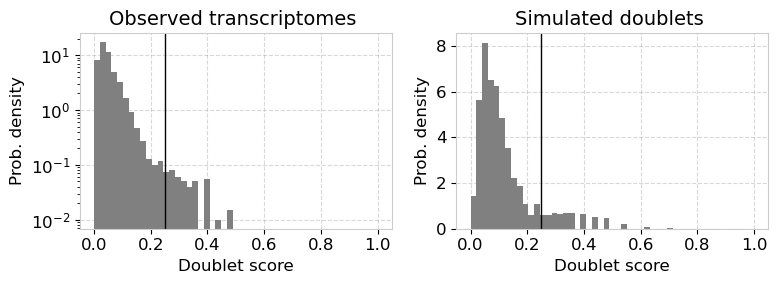

Number of duplets with threshold 0.25: 87

Loading sample 88...

CALCULA DOUBLETS...


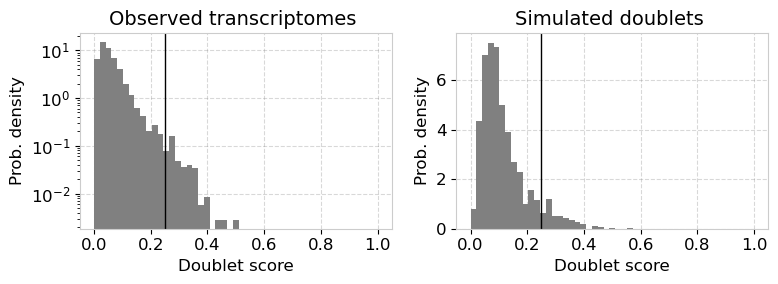

Number of duplets with threshold 0.25: 148

Loading sample 89...

CALCULA DOUBLETS...


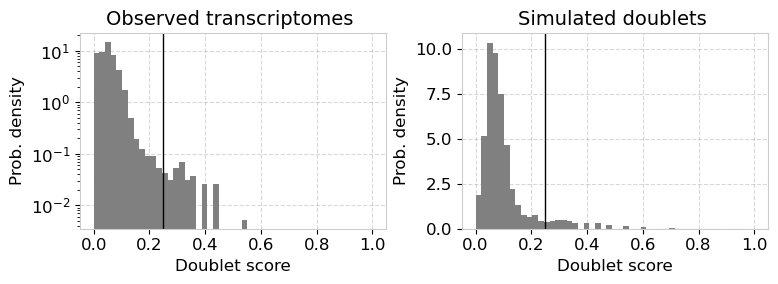

Number of duplets with threshold 0.25: 61

Loading sample 90...

CALCULA DOUBLETS...


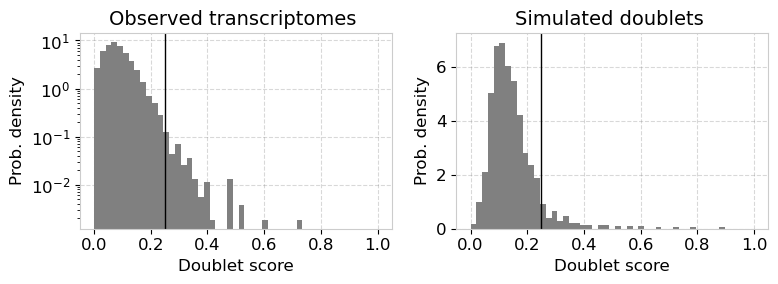

Number of duplets with threshold 0.25: 190
✅ AnnData concatenado com 32308 células e 17068 genes.
✅ AnnData concatenado com 63237 células e 33696 genes.


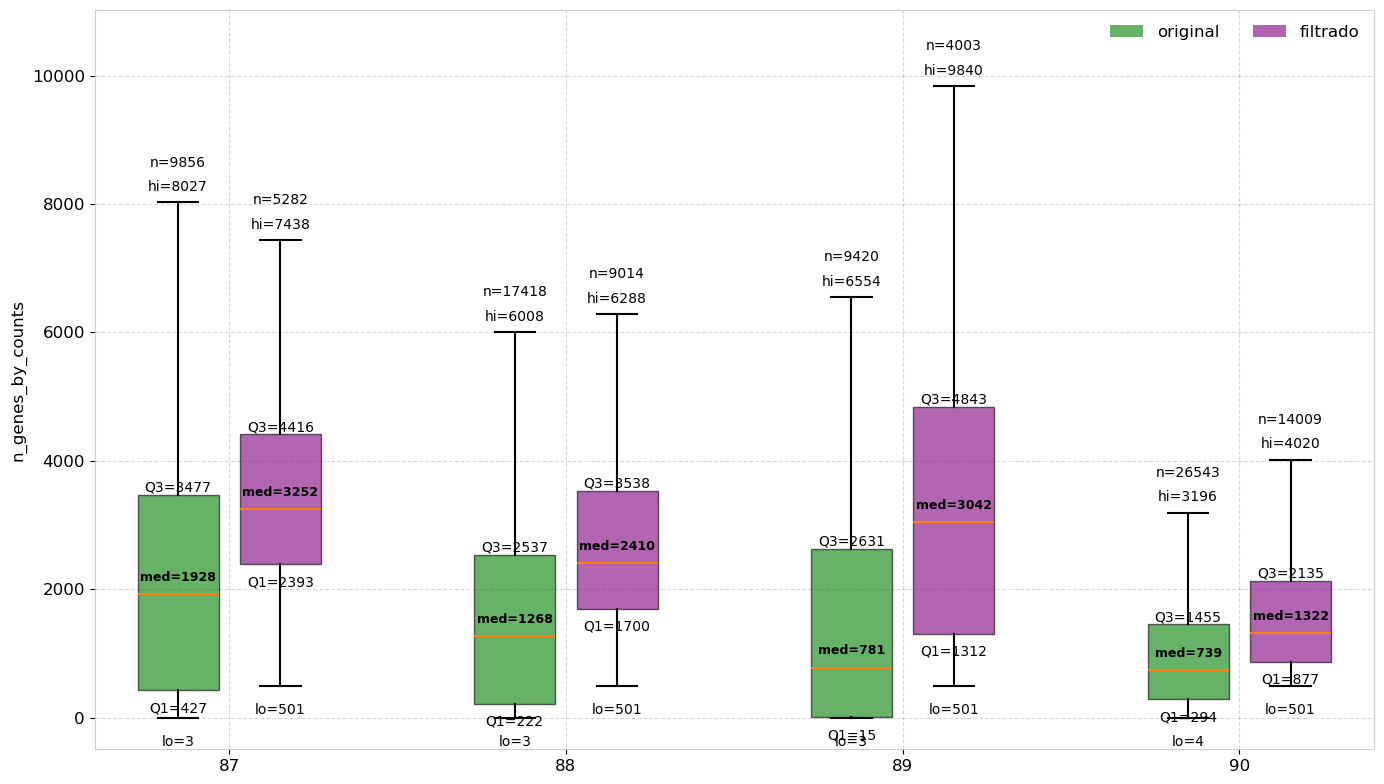

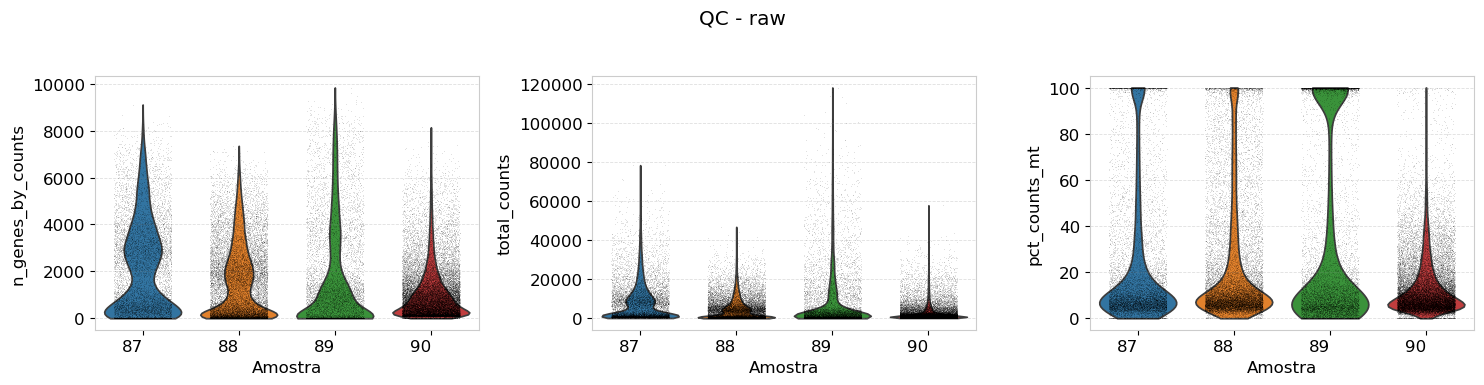

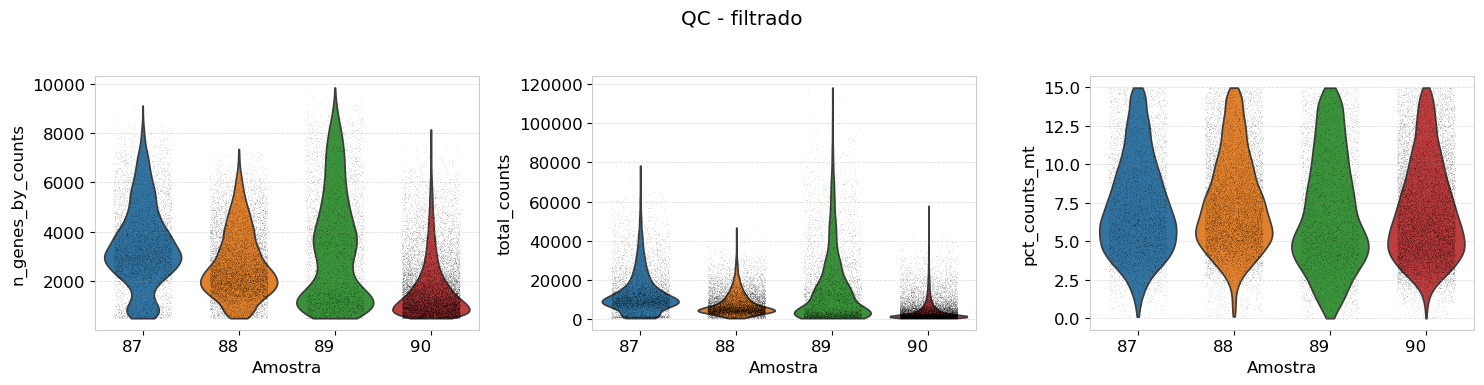

,87,88,89,90
Initial Cell Counts,9856.00,17418.00,9420.00,26543.00
Final Cell Counts,5282.00,9014.00,4003.00,14009.00
Initial Gene Counts,33696.00,33696.00,33696.00,33696.00
Final Gene Counts,16193.00,16431.00,15959.00,16223.00
Initial N Cell by Genes (Median),15.00,17.00,14.00,15.00
Final N Cell by Genes (Median),806.00,863.00,647.00,768.00
Initial N Genes by Cells (Median),1927.50,1267.50,781.00,739.00
Final N Genes by Cells (Median),3252.00,2410.50,3042.00,1322.00
Initial Pct counts in top 20 genes (Median),25.30,25.92,32.72,21.88
Final Pct counts in top 20 genes (Median),16.95,16.30,18.86,15.72


In [ ]:
# ====================================================
# STEP 1 — Exploratory QC and Scrublet inspection
# ====================================================
# This step runs QC_PT1 to:
# - Load raw and CellBender-corrected matrices
# - Compute initial QC metrics
# - Run Scrublet and generate diagnostic plots
# The goal is to inspect the Scrublet score distributions
# and decide on an appropriate doublet threshold.

samples1 = QC_PT1(
    samples=samples_dic,
    input_files_prefix=input_files_prefix,
    doublet_threshold=doublet_threshold,
    show_plot=show_plot,      # Set to False to suppress interactive plots
    save_plot=save_plot,      # Directory where QC plots will be saved
    x10=x10
)

# ====================================================
# STEP 2 — Final QC with fixed thresholds
# ====================================================
# After inspecting Scrublet results from QC_PT1 and
# defining the final doublet threshold, this step:
# - Filters doublets
# - Filters low-quality cells using QC cutoffs
# - Updates QC summaries
# - Concatenates all samples
# - Optionally exports AnnData objects and QC tables

adata_cellbender, adata_filtered, df_qc = QC_PT2(
    samples1,
    cutoffs_dic=cutoffs_dic,
    export_adata=export_adata,
    show_plot=False,          # QC plots already inspected in STEP 1
    save_plot=save_plot,
    doublet_threshold=doublet_threshold
)

# ====================================================
# QC violin plots — before filtering
# ====================================================
# Visualize QC metrics for CellBender-corrected data
# prior to doublet and outlier filtering.

PlotQCViolinsGrid(
    adata_cellbender,
    l_metricas=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    title="QC - raw",
    suffix='raw',
    sample_key='sample',
    samples=None,
    save_dir=f'{output_dir}/figures',
    show_plot=True
)

# ====================================================
# QC violin plots — after filtering
# ====================================================
# Visualize QC metrics after doublet removal and
# low-quality cell filtering.

PlotQCViolinsGrid(
    adata_filtered,
    l_metricas=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    title="QC - filtered",
    suffix='filtered',
    sample_key='sample',
    samples=None,
    save_dir=f'{output_dir}/figures',
    show_plot=True
)

# ====================================================
# Export and inspect QC summary table
# ====================================================
# Save the final QC metrics table and display it.

df_qc.to_csv(f"{output_dir}/Tabela_metricas_filter.csv", sep='\t')
df_qc
